## Regression Prediction

### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LinearRegression

### Prepare data

#### Input and delete uneccessary data

In [ ]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
df.shape

(289, 1147)

In [ ]:
# Calculate the total case of each country/region
df = df.groupby('Country/Region').sum()

# Delete uneccessary coulumn: Province/State, Lat, Long
df.drop(columns = ['Province/State', 'Lat', 'Long'], inplace=True)

# add index
df.reset_index(inplace=True)

df.shape

(201, 1144)

#### Choose top 3 countries having most infection cases

In [ ]:
# Choose top 3 values on Total Cases
top_values = df.iloc[:,-1].nlargest(3).tolist()

# Filter the rows and results in dataframe
top_rows = df[df.iloc[:,-1].isin(top_values)]

df = top_rows
df

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
63,France,0,0,2,3,3,3,4,5,5,...,39827175,39831700,39835896,39839090,39839090,39839090,39847236,39854299,39860410,39866718
80,India,0,0,0,0,0,0,0,0,1,...,44687837,44688105,44688388,44688722,44689046,44689327,44689593,44689919,44690298,44690738
186,US,1,1,2,2,5,5,5,6,6,...,103443455,103533872,103589757,103648690,103650837,103646975,103655539,103690910,103755771,103802702


#### Change dataset format

In [ ]:
# Melt to long format
df = pd.melt(df, id_vars=['Country/Region'], var_name = 'date', value_name = 'infections')
df.head()


,Country/Region,date,infections
0,France,1/22/20,0
1,India,1/22/20,0
2,US,1/22/20,1
3,France,1/23/20,0
4,India,1/23/20,0


#### Group 7 days into week

In [ ]:
# Convert date column to datetime:
df['date'] = pd.to_datetime(df['date'])

# Calculate days since start
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days

# Truncate to week start by floor dividing days by 7
df['week'] = df['days_since_start'] // 7 + 1

df


,Country/Region,date,infections,days_since_start,week
0,France,2020-01-22,0,0,1
1,India,2020-01-22,0,0,1
2,US,2020-01-22,1,0,1
3,France,2020-01-23,0,1,1
4,India,2020-01-23,0,1,1
...,...,...,...,...,...
3424,India,2023-03-08,44690298,1141,164
3425,US,2023-03-08,103755771,1141,164
3426,France,2023-03-09,39866718,1142,164
3427,India,2023-03-09,44690738,1142,164


#### Calculate the infection cases for each week

In [ ]:
# Value of final day of each week = value of that week
df['max_infections'] = df.groupby(['Country/Region','week'])['infections'].transform('max')

df_week = df[['Country/Region', 'week','max_infections']]
df_week = df_week.drop_duplicates()
df_week = df_week.rename(columns={'max_infections':'week_value'})

df_week

,Country/Region,week,week_value
0,France,1,4
1,India,1,0
2,US,1,5
21,France,2,6
22,India,2,3
...,...,...,...
3403,India,163,44689919
3404,US,163,103690910
3423,France,164,39866718
3424,India,164,44690738


#### Handling with outliers

Text(0.5, 1.0, '')

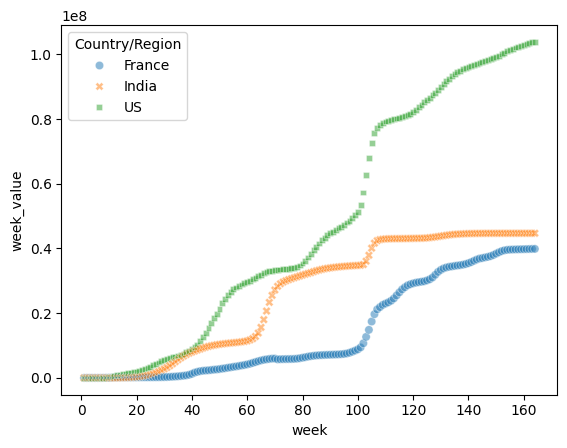

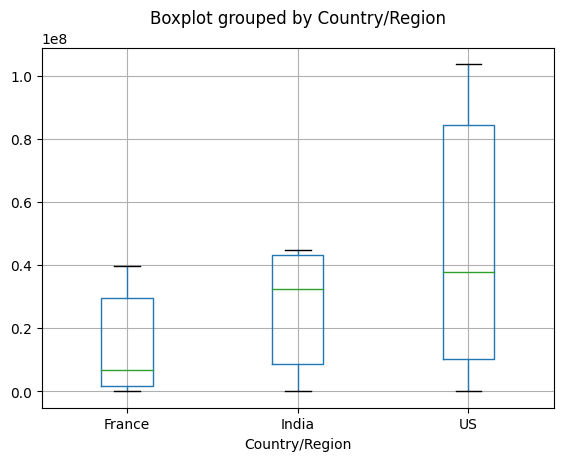

In [ ]:
sns.scatterplot(x='week', y='week_value', hue='Country/Region', data=df_week, style='Country/Region', alpha = 0.5)

df_week.boxplot(column = 'week_value', by = 'Country/Region')
plt.title('')

In [ ]:
by_country_week = df_week.drop(columns = 'week').groupby('Country/Region')
outliers = pd.DataFrame()

for country, group in by_country_week:
  Q1 = group['week_value'].quantile(0.25)
  Q3 = group['week_value'].quantile(0.75)
  IQR = Q3 - Q1
  minimun = Q1 - 1.5*IQR
  maximun = Q3 + 1.5*IQR

  outliers_subset = group[(group['week_value'] < minimun) | (group['week_value'] > maximun)]

  outliers = pd.concat([outliers, outliers_subset])

outliers

,Country/Region,week_value


In [ ]:
mask = ~(df_week['Country/Region'].isin(outliers['Country/Region']) &
         df_week['week_value'].isin(outliers['week_value']))
df_week = df_week[mask].reset_index(drop=True)

df_week

,Country/Region,week,week_value
0,France,1,4
1,India,1,0
2,US,1,5
3,France,2,6
4,India,2,3
...,...,...,...
487,India,163,44689919
488,US,163,103690910
489,France,164,39866718
490,India,164,44690738


Text(0.5, 1.0, '')

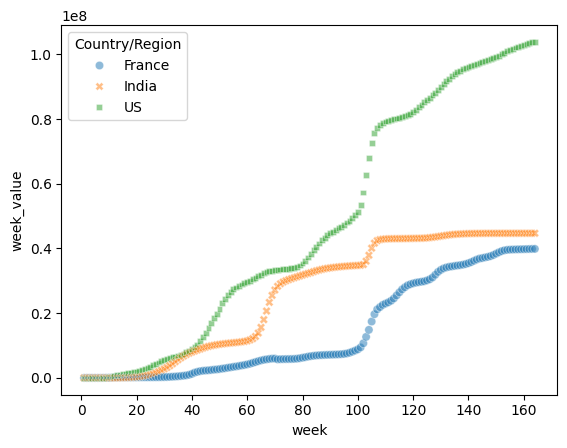

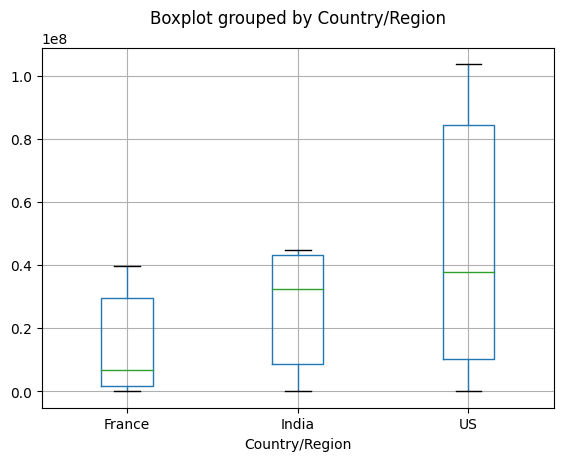

In [ ]:
sns.scatterplot(x='week', y='week_value', hue='Country/Region', data=df_week, style='Country/Region', alpha = 0.5)

df_week.boxplot(column = 'week_value', by = 'Country/Region')
plt.title('')

 ### Fit a linear regression model

In [ ]:
df_week

,Country/Region,week,week_value
0,France,1,4
1,India,1,0
2,US,1,5
3,France,2,6
4,India,2,3
...,...,...,...
487,India,163,44689919
488,US,163,103690910
489,France,164,39866718
490,India,164,44690738


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
#standardScaler = StandardScaler()
#columns_to_scale = ["week_value"]
#df_week[columns_to_scale] = standardScaler.fit_transform(df_week[columns_to_scale])

In [ ]:
# Split data into country groups
country_groups = df_week.groupby('Country/Region')

In [ ]:
# Fit models
models = {}
r_squared = {}
r2 ={}
rss ={}
MSE ={}
for name, group in country_groups:
  # Define x_axis
  X = group['week'].to_numpy()
  X = X[:, np.newaxis]

  # Define y_axis
  y = group['week_value'].to_numpy()

  # Split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

  # Fit model
  lr = LinearRegression().fit(X_train, y_train)
  models[name] = lr

  # Loss function
  r_squared[name] = lr.score(X_test, y_test)
  rss[name] = np.mean((lr.predict(X_test) - y_test) ** 2)

  y_pred = lr.predict(X_test)
  r2[name] = r2_score(y_test, y_pred)

  MSE[name] = mean_squared_error(y_test, y_pred)

In [ ]:
print(r_squared)
print(rss)
print(r2)
print(MSE)

{'France': 0.8864384038062442, 'India': 0.923696224939991, 'US': 0.9715470303213734}
{'France': 26495063029253.523, 'India': 23211476146445.516, 'US': 38545660273152.07}
{'France': 0.8864384038062442, 'India': 0.923696224939991, 'US': 0.9715470303213734}
{'France': 26495063029253.523, 'India': 23211476146445.516, 'US': 38545660273152.07}


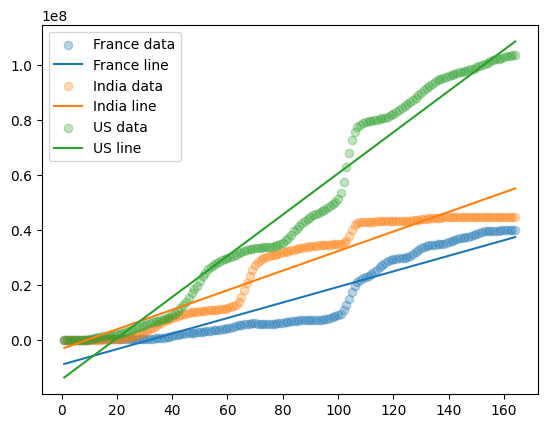

In [ ]:
# Plot each group
for name, group in country_groups:

   plt.scatter(group['week'], group['week_value'], label= name + ' data', alpha = 0.3)

   X_plot = np.linspace(group['week'].min(), group['week'].max())

   plt.plot(X_plot, models[name].predict(X_plot[:,np.newaxis]),
            label= name + ' line')

plt.legend()
plt.show()

## Clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
df_week

,Country/Region,week,week_value
0,France,1,4
1,India,1,0
2,US,1,5
3,France,2,6
4,India,2,3
...,...,...,...
487,India,163,44689919
488,US,163,103690910
489,France,164,39866718
490,India,164,44690738


In [ ]:
# Get items from MSE dictionary as (country, value) tuples
mse_items = MSE.items()

# Sort tuples by MSE value
mse_items = sorted(mse_items, key=lambda x: x[1], reverse=True)

# Highest MSE value is the first item
highest_mse_country = mse_items[0][0]
highest_mse_value = mse_items[0][1]

# Filter dataframe
filtered_df = df_week[df_week['Country/Region'] == highest_mse_country]
cluster_df = filtered_df.reset_index(drop=True)

In [ ]:
cluster_df

,Country/Region,week,week_value
0,US,1,5
1,US,2,11
2,US,3,13
3,US,4,14
4,US,5,16
...,...,...,...
159,US,160,102934224
160,US,161,103198669
161,US,162,103443455
162,US,163,103690910


In [ ]:
cluster_df.index = cluster_df['week']
cluster_df = cluster_df.drop(columns = 'week')

In [ ]:
cluster_df

,Country/Region,week_value
week,,
1,US,5
2,US,11
3,US,13
4,US,14
5,US,16
...,...,...
160,US,102934224
161,US,103198669
162,US,103443455


In [ ]:
#Initialize variable
x_raw = cluster_df["week_value"].to_numpy()
x_raw = np.reshape(x_raw, [-1,1])

In [ ]:
scaler = StandardScaler().fit(x_raw)
scaler
x_scaled = scaler.transform(x_raw)

In [ ]:
x_scaled

array([[-1.30033759],
       [-1.30033742],
       [-1.30033737],
       [-1.30033734],
       [-1.30033729],
       [-1.3003357 ],
       [-1.30031635],
       [-1.30015976],
       [-1.29878779],
       [-1.29508839],
       [-1.28898918],
       [-1.28319407],
       [-1.27777822],
       [-1.27233002],
       [-1.26715152],
       [-1.26263294],
       [-1.25837153],
       [-1.25427753],
       [-1.25034365],
       [-1.24629519],
       [-1.24196583],
       [-1.23614869],
       [-1.2279487 ],
       [-1.21818975],
       [-1.20630433],
       [-1.19384328],
       [-1.18143282],
       [-1.17035197],
       [-1.15939147],
       [-1.14991885],
       [-1.14191754],
       [-1.13394613],
       [-1.12689227],
       [-1.11938878],
       [-1.11141295],
       [-1.10336972],
       [-1.09504685],
       [-1.08524404],
       [-1.07344351],
       [-1.05962333],
       [-1.04165953],
       [-1.01798047],
       [-0.9875763 ],
       [-0.95345435],
       [-0.92137315],
       [-0

In [ ]:
k_summary = np.zeros([10,2])

for kk in range(1, 11):
  kmeans = KMeans(n_clusters=kk, random_state=0).fit(x_scaled)
  k_summary[kk-1,0] = kk
  k_summary[kk-1,1] = -kmeans.score(x_scaled)


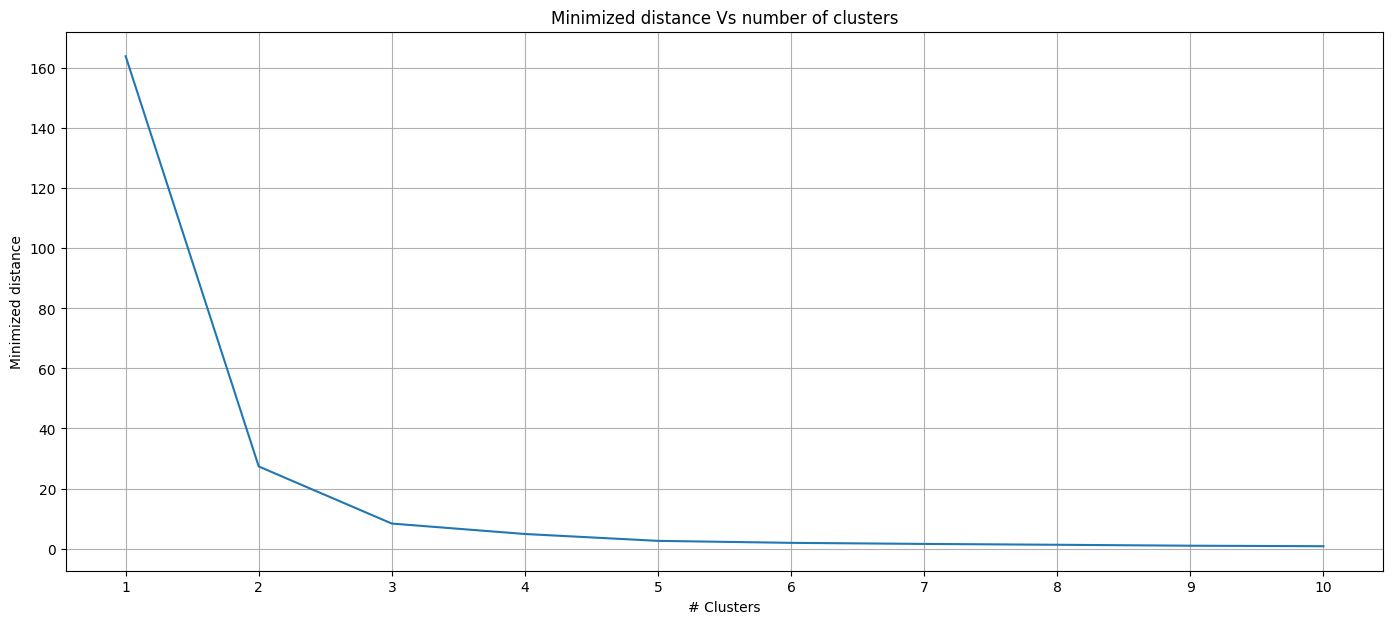

In [ ]:
fig, axs = plt.subplots(1, 1, sharex="col")
fig.set_size_inches(17,7)
axs.plot(k_summary[:,0], k_summary[:,1])
axs.set_title("Minimized distance Vs number of clusters")
axs.grid(True)
plt.ylabel("Minimized distance")
plt.xlabel("# Clusters")
plt.xticks(k_summary[:,0])
plt.show()

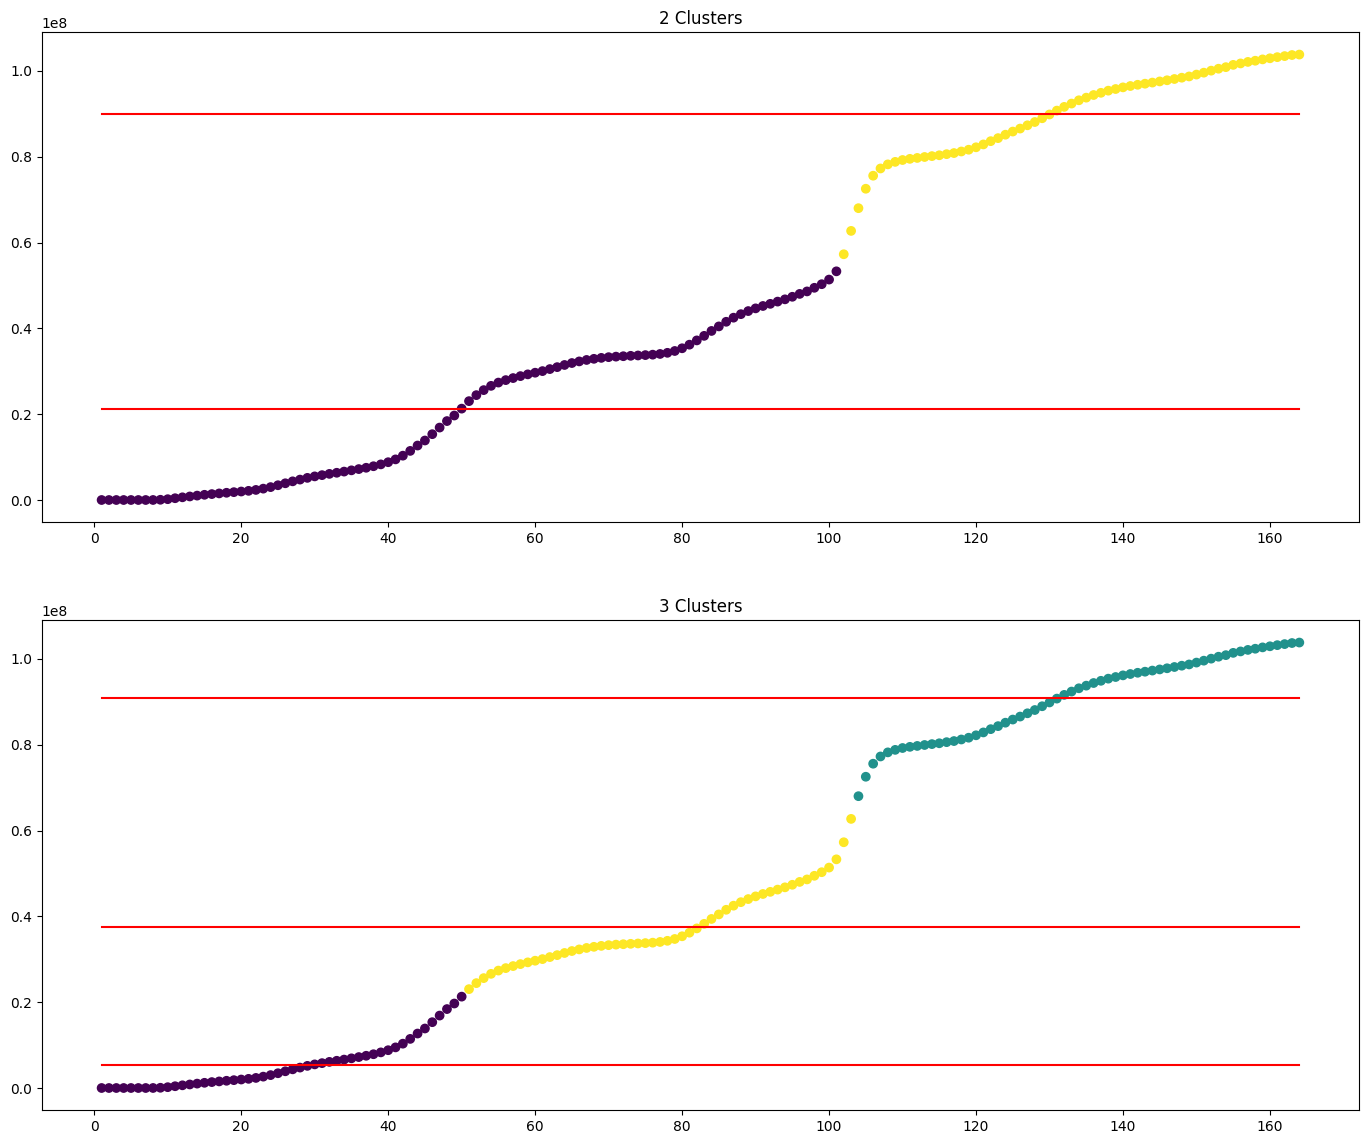

In [ ]:
#Plot the best Clustering
k_best = [2, 3]
fig, axs = plt.subplots(len(k_best), 1)
fig.set_size_inches(17,7*len(k_best))
ind = 0
for kk in k_best:
  kmeans = KMeans(n_clusters=kk, random_state=0).fit(x_scaled)
  axs[ind].scatter(cluster_df.index, x_raw, c=kmeans.labels_)
  for centroid in kmeans.cluster_centers_:
    axs[ind].plot(cluster_df.index, np.ones_like(cluster_df.index, dtype = "float64")*scaler.inverse_transform(centroid.reshape(-1,1))[0], "r")
  axs[ind].set_title(str(kk)+" Clusters")
  ind = ind + 1

plt.show()

#####

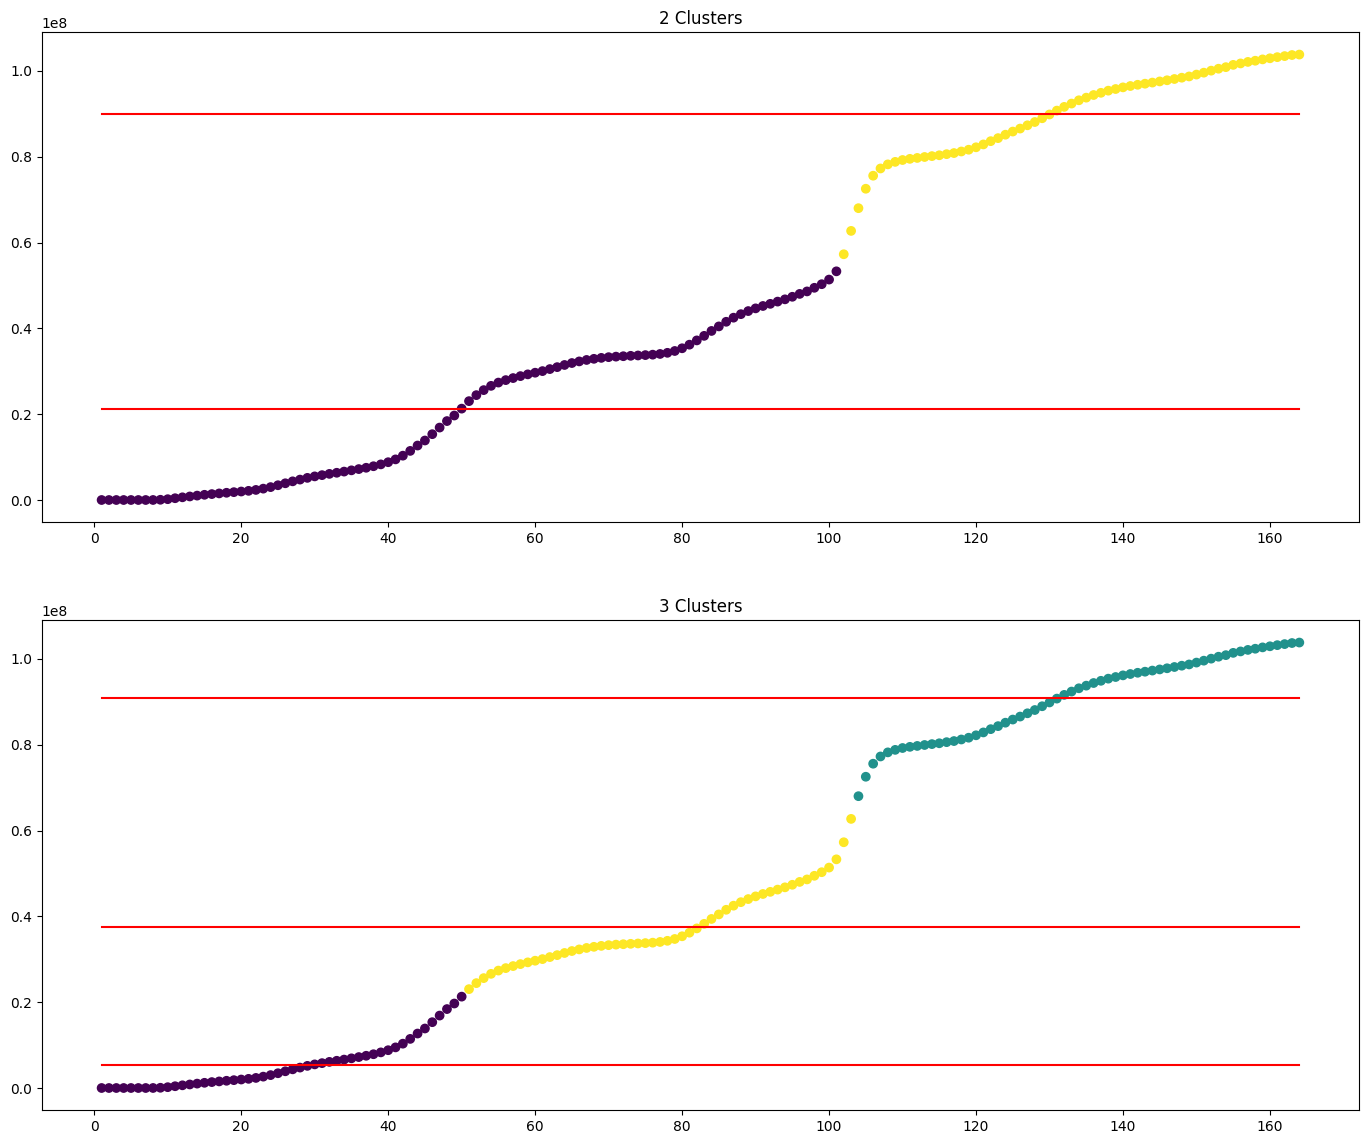

In [ ]:
#Plot the best Clustering
k_best = [2, 3]
fig, axs = plt.subplots(len(k_best), 1)
fig.set_size_inches(17,7*len(k_best))
ind = 0
for kk in k_best:
  kmeans = KMeans(n_clusters=kk, random_state=0).fit(x_scaled)
  axs[ind].scatter(cluster_df.index, x_raw, c=kmeans.labels_)
  for centroid in kmeans.cluster_centers_:
    axs[ind].plot(cluster_df.index, np.ones_like(cluster_df.index, dtype = "float64")*scaler.inverse_transform(centroid.reshape(-1,1))[0], "r")
  axs[ind].set_title(str(kk)+" Clusters")
  ind = ind + 1

plt.show()

In [ ]:
#Transition matrix
Trans_df = cluster_df.copy(deep = True)
Trans_df["Old Label_t"] = kmeans.labels_
Trans_df["New Label_t"] = np.zeros_like(Trans_df["Old Label_t"])
Dict_df = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns = ["Centroids"])
Dict_df.sort_values(by=['Centroids'], inplace=True)

for ii in Trans_df.index:
  Trans_df["New Label_t"].at[ii] = Dict_df.index[Trans_df["Old Label_t"][ii]]




Trans_df["Label_t+1"] = Trans_df["New Label_t"].shift(periods=-1)
unique = np.unique(Trans_df["New Label_t"])
Trans_prob = np.zeros([len(unique),len(unique)])
for u1 in unique:
  #Tot_row = np.count_nonzero(Trans_df["New Label_t"] == u1)
  for u2 in unique:
    Trans_prob[u1, u2] = np.count_nonzero(np.logical_and(Trans_df["New Label_t"] == u1, Trans_df["Label_t+1"] == u2))#/Tot_row

Trans_m = pd.DataFrame( data = Trans_prob, columns = unique)
print ("Row = start cluster; Column = end cluster")
Trans_m

Row = start cluster; Column = end cluster


,0,1,2
0,49.0,1.0,0.0
1,0.0,52.0,1.0
2,0.0,0.0,60.0


In [ ]:
Trans_df[np.logical_and(Trans_df["New Label_t"] == 1, Trans_df["Label_t+1"] == 1)]

,Country/Region,week_value,Old Label_t,New Label_t,Label_t+1
week,,,,,
51,US,23040116,2,1,1.0
52,US,24439496,2,1,1.0
53,US,25608948,2,1,1.0
54,US,26600309,2,1,1.0
55,US,27364113,2,1,1.0
56,US,27939999,2,1,1.0
57,US,28414848,2,1,1.0
58,US,28873096,2,1,1.0
59,US,29278673,2,1,1.0
